In [1]:
from nestmodel.centralities import calc_pagerank
from convergence_helper import MultiTracker, ParameterWrapper, compute_on_all_datasets, save_results
from convergence_helper import get_datasets, get_samples

[]

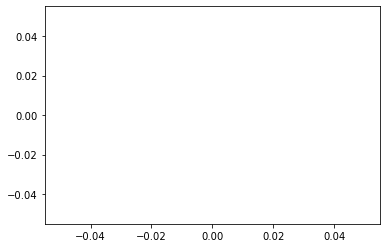

In [2]:
import matplotlib.pyplot as plt
# workaround plot otherwise setting the font does not work :(
plt.plot()

In [3]:
# Code that should make matplotlib use ACM font (libertine)
import matplotlib
import shutil
latex_exists = shutil.which("latex") is not None
rc_fonts = {
    "font.family": "serif",
    "font.size": 18,
    'figure.figsize': (5, 3),
    "text.usetex": latex_exists,
    'text.latex.preamble': 
        r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
}
matplotlib.rcParams.update(rc_fonts)

In [4]:
import numpy as np

from matplotlib.ticker import FixedLocator, ScalarFormatter


In [5]:
datasets = [ "HepPh", ]

In [6]:
glob_pagerank = None
def wrapper_fun(pagerank, base_pagerank):
    global glob_pagerank
    glob_pagerank = base_pagerank
    return pagerank

In [7]:
tracker = MultiTracker(("jaccard",), (wrapper_fun,))
params = ParameterWrapper(
dataset_path = None,
cent_func    = calc_pagerank,   
cent_kwargs  = {},
rewire_kwargs =    {"method":1},
wl_kwargs = {"initial_colors":"out_degree", "both":False},
number_of_samples=get_samples(1)
)


params.verbosity=1
tracker.verbosity=1
params.tqdm=1
compute_on_all_datasets(get_datasets(datasets), tracker, params)

dataset: HepPh
resetting
	total WL iterations  4


wl_rounds:   0%|          | 0/4 [00:00<?, ?it/s]

samples:   0%|          | 0/1 [00:00<?, ?it/s]

samples:   0%|          | 0/1 [00:00<?, ?it/s]

samples:   0%|          | 0/1 [00:00<?, ?it/s]

samples:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
from numba import njit
@njit
def get_CDF(v, include_zero=False):
    """Compute the CDF (cummulative distribution function)"""
    v=v.copy()
    v.sort()
    
    max_len=len(v)
    if include_zero:
        max_len+=1
    y = np.zeros(max_len)
    x = np.zeros(max_len)
    i=0
    if include_zero:
        y[0]=len(v)
        x[0]=0
        i+=1
    count = 0
    unique_counter=0
    while i < len(v):
        last_value=v[i]
        while (i < len(v)) and (last_value==v[i]):
            i+=1
            count+=1
        y[unique_counter]=1+len(v)-count
        x[unique_counter]=last_value
        unique_counter+=1
    return x[:unique_counter], y[:unique_counter]

In [9]:
pageranks = list(tracker.to_df()["value"])
pageranks= pageranks[::-1]

In [10]:
dpi=600

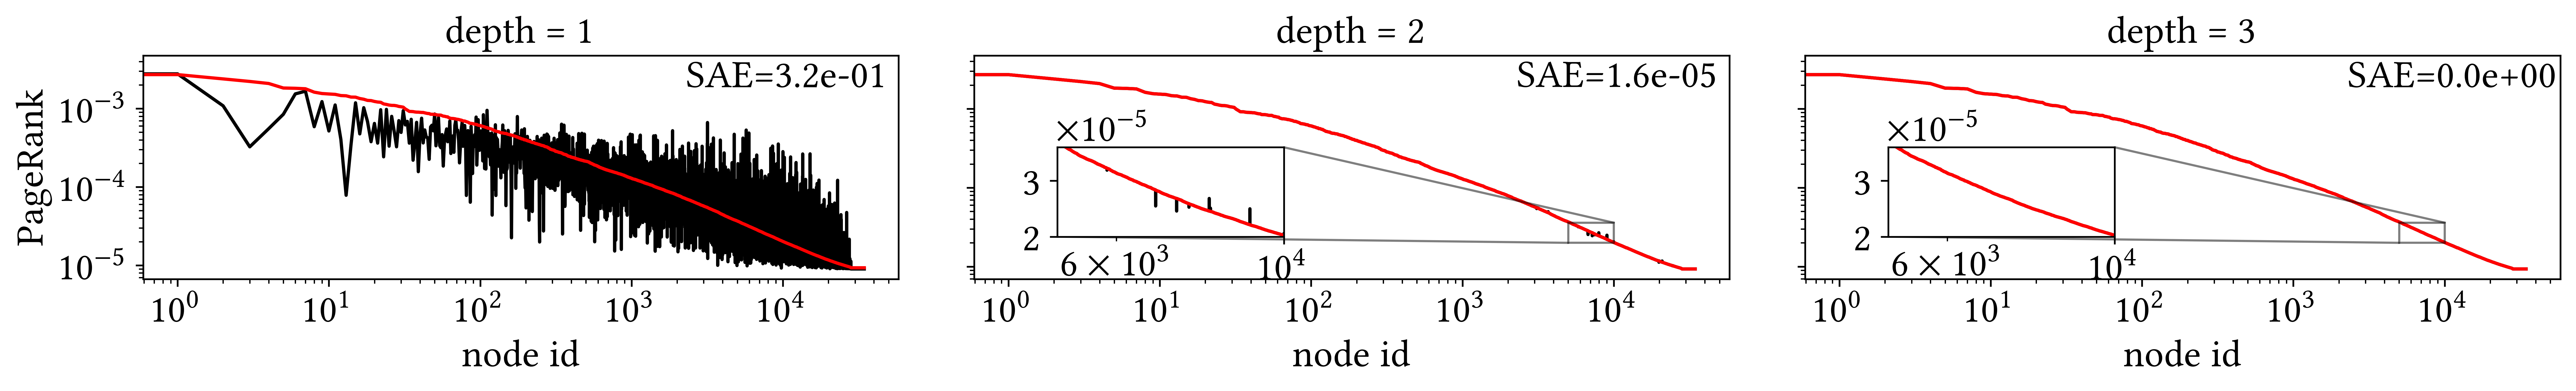

In [11]:
x=np.arange(len(glob_pagerank))[::-1]
inds= np.argsort(glob_pagerank)
y0=glob_pagerank[inds]
#plt.figure(figsize=(10,2))
max_depth=len(pageranks)
fig, axs_all = plt.subplots(1,max_depth-1,figsize=(20,1.9),dpi=dpi)
num_samples = 1
axs=axs_all#[0,:]
for j in range(0,max_depth-1):
    ax = axs[j]
    
    ax.plot(x,pageranks[j][inds], color="k")
        #axs[1,j].plot(x,arr[inds]-y0, color="r")
    ax.plot(x,y0, color="r")
    


    ax.set_title(f"depth = {j+1}", fontsize=18)
    ax.set_xlabel("node id")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_yticks([1e-3,1e-4,1e-5])
    
    ax.set_xticks([1,10,100,1000,10000])
    #ax.axes.xaxis.set_ticklabels([])
    if j >0:
        ax.axes.yaxis.set_ticklabels([])
    else:
        ax.set_ylabel("PageRank")
    SAE = np.sum(np.abs(pageranks[j][inds]-glob_pagerank[inds]))
    plt.text(0.72, 0.86, f"SAE={SAE:1.1e}", transform=ax.transAxes, fontsize=18)
plt.subplots_adjust(wspace=0.1, hspace=0)




# inset axes....


for j in [2,3]:
    axins = axs[j-1].inset_axes([0.11, 0.19, 0.3, 0.4], xticklabels=[], yticklabels=[])
    ax = axins
    ax.plot(x,pageranks[j-1][inds], color="k")
        #axs[1,j].plot(x,arr[inds]-y0, color="r")
    ax.plot(x,y0, color="r")
    
    
    #axins.imshow(Z2, extent=extent, origin="lower")
    # sub region of the original image
    x1, x2, y1, y2 = 10**3.7, 10**4, 2*10**-5, 3.6*10**-5
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    #axins.set_xticklabels([ 10**4])
    axins.yaxis.set_major_locator(FixedLocator([2*10**-5, 3*10**-5]))
    axins.yaxis.set_major_formatter(ScalarFormatter())
    #axins.set_yticklabels([2*10**-5, 4*10**-5])
    axins.set_xscale("log")
    #axins.set_yscale("log")
    axins.xaxis.set_minor_locator(FixedLocator([6*10**3]))
    #minorticks_off()
    #axins.ticklabel_format(axis='y', scilimits=[-2, 2])

    axs[j-1].indicate_inset_zoom(axins, edgecolor="black")
fig.savefig("./results/convergence-in-distribution.png")